In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/coil-20.zip'

In [ ]:
import zipfile
import os

extract_path = '/content/coil-20'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
print("Files in extracted folder:", os.listdir(extract_path)[:10])  # show first 10 files


Files in extracted folder: ['coil-20', '__MACOSX']


## Setup and data loading



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from scipy import stats
import matplotlib.pyplot as plt
import os

# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Load the dataset
dataset_path = '/content/coil-20/coil-20'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


batch_size = 64
dataloader_for_mean_std = DataLoader(dataset, batch_size=batch_size, shuffle=False)


num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")


mean = 0.
std = 0.
nb_samples = 0.
for data, _ in dataloader_for_mean_std:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Calculated Mean: {mean}")
print(f"Calculated Std Dev: {std}")


transform_normalized = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


dataset_normalized = datasets.ImageFolder(root=dataset_path, transform=transform_normalized)
dataloader = DataLoader(dataset_normalized, batch_size=batch_size, shuffle=True)

print(f"Dataset loaded and DataLoader created with batch size {batch_size}.")

Number of classes: 20
Calculated Mean: tensor([0.3022])
Calculated Std Dev: tensor([0.2893])
Dataset loaded and DataLoader created with batch size 64.


## Mathematical formulation




## Mathematical Formulation of VAE+DEC

The VAE+DEC model combines a Variational Autoencoder (VAE) for learning a latent representation with a Deep Embedded Clustering (DEC) approach for clustering in the latent space.

### Variational Autoencoder (VAE)

A VAE aims to learn a probabilistic mapping from the input data $\mathbf{x}$ to a latent space $\mathbf{z}$ and back. It consists of an encoder and a decoder.

The **encoder** learns the approximate posterior distribution $q_{\phi}(\mathbf{z}|\mathbf{x})$, typically assumed to be a multivariate Gaussian with diagonal covariance:
$$ q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\phi}(\mathbf{x}), \text{diag}(\sigma^2_{\phi}(\mathbf{x}))) $$
where $\mu_{\phi}(\mathbf{x})$ and $\sigma^2_{\phi}(\mathbf{x})$ are the mean and variance predicted by the encoder network with parameters $\phi$.

The **decoder** learns the likelihood of the data given the latent variable $p_{\theta}(\mathbf{x}|\mathbf{z})$. For image data with pixel values between 0 and 1, a common choice is a Bernoulli distribution, parameterized by a sigmoid output layer:
$$ p_{\theta}(\mathbf{x}|\mathbf{z}) = \text{Bernoulli}(\mathbf{x} | \text{sigmoid}(f_{\theta}(\mathbf{z}))) $$
where $f_{\theta}(\mathbf{z})$ is the output of the decoder network with parameters $\theta$.

The VAE is trained by minimizing an evidence lower bound (ELBO), which can be decomposed into a reconstruction loss and a KL divergence term.

The **reconstruction loss** measures how well the decoder can reconstruct the input data from the latent representation. For Bernoulli likelihood and sigmoid output, it is typically the Binary Cross-Entropy (BCE):
$$ \mathcal{L}_{recon}(\theta, \phi) = -\mathbb{E}_{q_{\phi}(\mathbf{z}|\mathbf{x})} [\log p_{\theta}(\mathbf{x}|\mathbf{z})] $$
For a single data point $\mathbf{x}$ and its reconstruction $\hat{\mathbf{x}}$, this is often approximated by:
$$ \mathcal{L}_{recon} \approx -\sum_{i=1}^{D} [x_i \log \hat{x}_i + (1 - x_i) \log (1 - \hat{x}_i)] $$
where $D$ is the dimension of the input data and $\hat{\mathbf{x}} = \text{sigmoid}(f_{\theta}(\mathbf{z}))$.

The **KL divergence** term acts as a regularizer, forcing the approximate posterior $q_{\phi}(\mathbf{z}|\mathbf{x})$ to be close to a prior distribution $p(\mathbf{z})$, typically a standard normal distribution $\mathcal{N}(\mathbf{0}, \mathbf{I})$.
$$ \mathcal{L}_{KL}(\phi) = D_{KL}(q_{\phi}(\mathbf{z}|\mathbf{x}) || p(\mathbf{z})) $$
For Gaussian $q_{\phi}$ and standard Gaussian prior, the KL divergence has a closed-form solution:
$$ \mathcal{L}_{KL} = \frac{1}{2} \sum_{j=1}^{L} (1 + \log(\sigma^2_j) - \mu_j^2 - \sigma^2_j) $$
where $L$ is the dimension of the latent space, and $\mu_j$ and $\sigma^2_j$ are the elements of $\mu_{\phi}(\mathbf{x})$ and $\sigma^2_{\phi}(\mathbf{x})$, respectively.

The total VAE loss is the sum of the reconstruction loss and the KL divergence:
$$ \mathcal{L}_{VAE} = \mathcal{L}_{recon} + \mathcal{L}_{KL} $$

### Deep Embedded Clustering (DEC)

DEC performs clustering in the latent space learned by the VAE. It iteratively refines the clustering by optimizing a clustering loss based on the difference between a soft assignment distribution $Q$ and a target distribution $P$.

**Soft Assignments (Q):** The soft assignment $q_{ij}$ represents the probability that latent point $\mathbf{z}_i$ belongs to cluster $j$. This is calculated using the Student's t-distribution as a kernel to measure the similarity between the latent point $\mathbf{z}_i$ and the centroid $\mu_j$ of cluster $j$:
$$ q_{ij} = \frac{(1 + ||\mathbf{z}_i - \mu_j||^2 / \alpha)^{-(\alpha+1)/2}}{\sum_{j'=1}^{K} (1 + ||\mathbf{z}_i - \mu_{j'}||^2 / \alpha)^{-(\alpha+1)/2}} $$
where $K$ is the number of clusters, $\mu_j$ are the cluster centroids (initialized by KMeans on the latent representations), and $\alpha$ is the degrees of freedom (typically set to 1).

**Target Distribution (P):** The target distribution $p_{ij}$ is a smoothed version of $Q$, designed to put more emphasis on data points with high confidence assignments and normalize the contribution of each cluster. It is calculated as:
$$ p_{ij} = \frac{q_{ij}^2 / \sum_{i'=1}^{N} q_{i'j}}{\sum_{j'=1}^{K} (q_{ij'}^2 / \sum_{i'=1}^{N} q_{i'j'})} $$
where $N$ is the total number of data points. This distribution is updated periodically during training.

**Clustering Loss:** The clustering loss is the KL divergence between the target distribution $P$ and the soft assignment distribution $Q$:
$$ \mathcal{L}_{cluster} = D_{KL}(P || Q) = \sum_{i=1}^{N} \sum_{j=1}^{K} p_{ij} \log \frac{p_{ij}}{q_{ij}} $$
Minimizing this loss encourages the model to refine the cluster assignments and move the centroids towards regions of high data density.

### VAE+DEC Total Loss

The total loss function for the VAE+DEC model is a weighted sum of the VAE loss components and the clustering loss:
$$ \mathcal{L}_{total} = \mathcal{L}_{recon} + \beta \mathcal{L}_{KL} + \gamma \mathcal{L}_{cluster} $$
where $\beta$ and $\gamma$ are hyperparameters controlling the influence of the KL divergence and clustering loss, respectively. In this assignment, we use $\beta=1.0$ and $\gamma=1.0$.


## Model architecture definition




In [ ]:
import torch.nn.functional as F

class VAE_DEC(nn.Module):
    def __init__(self, input_channels=1, latent_dim=10, num_clusters=20):
        super(VAE_DEC, self).__init__()

        self.latent_dim = latent_dim
        self.num_clusters = num_clusters


        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=2, padding=2), # Output: 16x16x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), # Output: 8x8x64
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # Output: 4x4x128
            nn.ReLU(),
            nn.Flatten() # Output: 4*4*128 = 2048
        )

        self.fc_mu = nn.Linear(4 * 4 * 128, latent_dim)
        self.fc_logvar = nn.Linear(4 * 4 * 128, latent_dim)

        # Decoder layers
        self.decoder_input = nn.Linear(latent_dim, 4 * 4 * 128)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # Output: 8x8x64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: 16x16x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=5, stride=2, padding=2, output_padding=1), # Output: 32x32x1
            nn.Sigmoid()
        )


        self.clustering_layer = nn.Linear(latent_dim, num_clusters)

        self.cluster_centroids = nn.Parameter(torch.Tensor(num_clusters, latent_dim))
        torch.nn.init.xavier_uniform_(self.cluster_centroids)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)


        decoded = self.decoder_input(z)
        reconstruction = self.decoder(decoded)


        sum_sq_z = torch.sum(z.pow(2), dim=1, keepdim=True)

        sum_sq_centroids = torch.sum(self.cluster_centroids.pow(2), dim=1, keepdim=True).T

        dot_product = z @ self.cluster_centroids.T

        distances = sum_sq_z + sum_sq_centroids - 2 * dot_product


        q = 1.0 / (1.0 + distances)
        q = q.pow((1 + 1.0) / 2.0)


        q = q / torch.sum(q, dim=1, keepdim=True)


        return reconstruction, mu, logvar, q, z

print("VAE_DEC class defined.")

VAE_DEC class defined.


In [ ]:
class VAE(nn.Module):
    def __init__(self, input_channels=1, latent_dim=10):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim


        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(4 * 4 * 128, latent_dim)
        self.fc_logvar = nn.Linear(4 * 4 * 128, latent_dim)


        self.decoder_input = nn.Linear(latent_dim, 4 * 4 * 128)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)


        decoded = self.decoder_input(z)
        reconstruction = self.decoder(decoded)

        return reconstruction, mu, logvar, z

print("VAE class defined.")

VAE class defined.


## Deterministic vae baseline


## Training loop and early stopping

In [ ]:
import torch
from torch.utils.data import random_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


latent_dim = 10
epochs = 50
beta = 1.0
gamma = 1.0
lr = 1e-3
update_target_interval = 5


model = VAE_DEC(input_channels=1, latent_dim=latent_dim, num_clusters=num_classes).to(device)
print("VAE_DEC model instantiated and moved to device.")


optimizer = optim.Adam(model.parameters(), lr=lr)
print("Optimizer defined.")

train_size = int(0.8 * len(dataset_normalized))
val_size = len(dataset_normalized) - train_size
train_dataset, val_dataset = random_split(dataset_normalized, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset split into {train_size} training and {val_size} validation samples.")
print(f"Training DataLoader created with batch size {batch_size}.")
print(f"Validation DataLoader created with batch size {batch_size}.")

Using device: cpu
VAE_DEC model instantiated and moved to device.
Optimizer defined.
Dataset split into 1152 training and 288 validation samples.
Training DataLoader created with batch size 64.
Validation DataLoader created with batch size 64.


In [ ]:
from sklearn.cluster import KMeans


print("Initializing cluster centroids with K-Means...")
model.eval()
all_latent_features = []
all_labels = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)

        _, _, _, _, z = model(images)
        all_latent_features.append(z.cpu().numpy())
        all_labels.append(labels.numpy())

all_latent_features = np.concatenate(all_latent_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=42)
kmeans.fit(all_latent_features)


model.cluster_centroids.data.copy_(torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device))

print("Cluster centroids initialized.")


from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy.
    # Arguments
        y_true: true labels, numpy.array
        y_pred: predicted labels, numpy.array
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = ind.T
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

kmeans_labels_pred = kmeans.labels_
initial_acc = cluster_acc(all_labels, kmeans_labels_pred)
initial_nmi = normalized_mutual_info_score(all_labels, kmeans_labels_pred)
initial_ari = adjusted_rand_score(all_labels, kmeans_labels_pred)

print(f"Initial K-Means clustering performance on training data latent features:")
print(f"  Accuracy: {initial_acc:.4f}")
print(f"  NMI: {initial_nmi:.4f}")
print(f"  ARI: {initial_ari:.4f}")

model.train()

Initializing cluster centroids with K-Means...
Cluster centroids initialized.
Initial K-Means clustering performance on training data latent features:
  Accuracy: 0.1068
  NMI: 0.0577
  ARI: 0.0004


VAE_DEC(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=2048, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=10, bias=True)
  (decoder_input): Linear(in_features=10, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (2): ReLU()
    (3): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspose2d(32, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (6): 

In [ ]:
recon_criterion = nn.BCELoss(reduction='sum')

def kl_divergence(mu, logvar):

    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

def clustering_loss_func(q, p):

    p = p.float()
    q = q.float()
    return torch.sum(p * torch.log(p / (q + 1e-8)))

def calculate_target_distribution(q):

    weight = q**2 / torch.sum(q, dim=0)

    p = (weight.T / torch.sum(weight, dim=1)).T

    p = torch.nan_to_num(p, nan=1.0/q.size(1), posinf=1.0/q.size(1), neginf=1.0/q.size(1))
    return p


best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

train_losses = []
val_losses = []
train_recon_losses = []
val_recon_losses = []
train_kl_losses = []
val_kl_losses = []
train_cluster_losses = []
val_cluster_losses = []

print("Starting training loop...")


class IndexedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

        if isinstance(self.dataset, torch.utils.data.Subset):
             self.original_indices = self.dataset.indices
        else:

             self.original_indices = list(range(len(self.dataset)))


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        data, label = self.dataset[idx]

        original_idx = self.original_indices[idx]

        return data, label, original_idx

train_indices = train_dataset.indices
val_indices = val_dataset.indices

indexed_train_dataset_norm = IndexedDataset(train_dataset)
indexed_val_dataset_norm = IndexedDataset(val_dataset)


original_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
original_indexed_dataset = IndexedDataset(original_dataset)
indexed_train_subset_original = torch.utils.data.Subset(original_indexed_dataset, train_indices)
indexed_val_subset_original = torch.utils.data.Subset(original_indexed_dataset, val_indices)


indexed_train_loader_norm = DataLoader(indexed_train_dataset_norm, batch_size=batch_size, shuffle=True)
indexed_val_loader_norm = DataLoader(indexed_val_dataset_norm, batch_size=batch_size, shuffle=False)


indexed_train_loader_original = DataLoader(indexed_train_subset_original, batch_size=batch_size, shuffle=True)
indexed_val_loader_original = DataLoader(indexed_val_subset_original, batch_size=batch_size, shuffle=False)


for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_train_recon_loss = 0
    total_train_kl_loss = 0
    total_train_cluster_loss = 0


    if epoch % update_target_interval == 0:
        print(f"Epoch {epoch}: Updating target distribution P...")
        model.eval()
        all_q = [None] * len(train_dataset)


        with torch.no_grad():

            for images_normalized, _, original_indices in indexed_train_loader_norm:
                images_normalized = images_normalized.to(device)
                _, _, _, q, _ = model(images_normalized)
                batch_q_cpu = q.cpu()

                for i, original_idx in enumerate(original_indices):
                    all_q[train_dataset.indices.index(original_idx)] = batch_q_cpu[i]



        all_q = torch.stack(all_q, dim=0)
        target_distribution_p = calculate_target_distribution(all_q).to(device)
        print("Target distribution P updated.")
        model.train()


    for (images_normalized, _, original_indices_norm), (images_original, _, original_indices_orig) in zip(indexed_train_loader_norm, indexed_train_loader_original):

        current_original_indices = original_indices_norm.to(device)

        images_normalized = images_normalized.to(device)
        images_original = images_original.to(device)
        optimizer.zero_grad()

        reconstruction, mu, logvar, q, z = model(images_normalized)


        recon_loss = recon_criterion(reconstruction.view(images_normalized.size(0), -1), images_original.view(images_original.size(0), -1))
        kl_loss = kl_divergence(mu, logvar)


        subset_indices = [train_dataset.indices.index(idx) for idx in original_indices_norm.tolist()]
        batch_p = target_distribution_p[subset_indices]

        cluster_loss = clustering_loss_func(q, batch_p)

        # Total loss
        total_loss = recon_loss + beta * kl_loss + gamma * cluster_loss

        # Backward pass and optimize
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item()
        total_train_recon_loss += recon_loss.item()
        total_train_kl_loss += kl_loss.item()
        total_train_cluster_loss += cluster_loss.item()


    avg_train_loss = total_train_loss / len(train_dataset)
    avg_train_recon_loss = total_train_recon_loss / len(train_dataset)
    avg_train_kl_loss = total_train_kl_loss / len(train_dataset)
    avg_train_cluster_loss = total_train_cluster_loss / len(train_dataset)


    train_losses.append(avg_train_loss)
    train_recon_losses.append(avg_train_recon_loss)
    train_kl_losses.append(avg_train_kl_loss)
    train_cluster_losses.append(avg_train_cluster_loss)


    # Evaluate on validation set
    model.eval()
    total_val_loss = 0
    total_val_recon_loss = 0
    total_val_kl_loss = 0


    with torch.no_grad():

        for (images_normalized, _, _), (images_original, _, _) in zip(indexed_val_loader_norm, indexed_val_loader_original):
            images_normalized = images_normalized.to(device)
            images_original = images_original.to(device)

            reconstruction, mu, logvar, q, z = model(images_normalized)


            recon_loss = recon_criterion(reconstruction.view(images_normalized.size(0), -1), images_original.view(images_original.size(0), -1))
            kl_loss = kl_divergence(mu, logvar)


            val_loss = recon_loss + beta * kl_loss

            total_val_loss += val_loss.item()
            total_val_recon_loss += recon_loss.item()
            total_val_kl_loss += kl_loss.item()

    avg_val_loss = total_val_loss / len(val_dataset)
    avg_val_recon_loss = total_val_recon_loss / len(val_dataset)
    avg_val_kl_loss = total_val_kl_loss / len(val_dataset)


    val_losses.append(avg_val_loss)
    val_recon_losses.append(avg_val_recon_loss)
    val_kl_losses.append(avg_val_kl_loss)


    print(f"Epoch [{epoch+1}/{epochs}], "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Train Recon: {avg_train_recon_loss:.4f}, "
          f"Train KL: {avg_train_kl_loss:.4f}, "
          f"Train Cluster: {avg_train_cluster_loss:.4f}, "
          f"Val VAE Loss: {avg_val_loss:.4f}, "
          f"Val Recon: {avg_val_recon_loss:.4f}, "
          f"Val KL: {avg_val_kl_loss:.4f}")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0

        print("Validation loss improved. Saving best model (optional).")
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("Training finished.")

Starting training loop...
Epoch 0: Updating target distribution P...
Target distribution P updated.
Epoch [1/50], Train Loss: 639.9895, Train Recon: 636.6603, Train KL: 3.0803, Train Cluster: 0.2489, Val VAE Loss: 562.8393, Val Recon: 552.4821, Val KL: 10.3573
Validation loss improved. Saving best model (optional).
Epoch [2/50], Train Loss: 554.4680, Train Recon: 548.5020, Train KL: 5.7118, Train Cluster: 0.2543, Val VAE Loss: 537.6778, Val Recon: 532.0658, Val KL: 5.6119
Validation loss improved. Saving best model (optional).
Epoch [3/50], Train Loss: 539.1156, Train Recon: 534.5903, Train KL: 4.2677, Train Cluster: 0.2576, Val VAE Loss: 533.3412, Val Recon: 529.2829, Val KL: 4.0583
Validation loss improved. Saving best model (optional).
Epoch [4/50], Train Loss: 536.5520, Train Recon: 532.4623, Train KL: 3.8348, Train Cluster: 0.2549, Val VAE Loss: 530.3049, Val Recon: 526.9207, Val KL: 3.3842
Validation loss improved. Saving best model (optional).
Epoch [5/50], Train Loss: 534.0899,

## Evaluation metrics



In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from scipy.optimize import linear_sum_assignment

def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy using the Hungarian algorithm.
    # Arguments
        y_true: true labels, numpy.array
        y_pred: predicted labels, numpy.array
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(w.max() - w)

    accuracy = sum([w[row_ind[i], col_ind[i]] for i in range(len(row_ind))]) * 1.0 / y_pred.size
    return accuracy

def calculate_nmi(y_true, y_pred):
    """
    Calculate Normalized Mutual Information (NMI).
    # Arguments
        y_true: true labels, numpy.array
        y_pred: predicted labels, numpy.array
    # Return
        NMI score
    """
    return normalized_mutual_info_score(y_true, y_pred)

def calculate_ari(y_true, y_pred):
    """
    Calculate Adjusted Rand Index (ARI).
    # Arguments
        y_true: true labels, numpy.array
        y_pred: predicted labels, numpy.array
    # Return
        ARI score
    """
    return adjusted_rand_score(y_true, y_pred)

def calculate_silhouette_score(X, labels):
    """
    Calculate Silhouette Score.
    # Arguments
        X: data points (latent features), numpy.array
        labels: predicted cluster labels, numpy.array
    # Return
        Silhouette Score
    """
    if len(np.unique(labels)) < 2:
        return -1
    return silhouette_score(X, labels)

print("Evaluation metric functions defined: cluster_acc, calculate_nmi, calculate_ari, calculate_silhouette_score.")

Evaluation metric functions defined: cluster_acc, calculate_nmi, calculate_ari, calculate_silhouette_score.


## Reproducibility and uncertainty analysis



In [ ]:
import random
import numpy as np
import torch

def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    print(f"Seeds set to {seed} for reproducibility.")


set_seed(42)

def analyze_uncertainty(model, dataloader, device, num_passes=10):
    """
    Analyzes uncertainty by performing multiple forward passes through the VAE encoder.
    Estimates uncertainty in the latent space (variance of z).
    """
    model.eval()
    all_latent_vars = []
    all_labels = []

    print(f"Starting uncertainty analysis with {num_passes} forward passes per sample.")

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            batch_latent_z = []
            for _ in range(num_passes):

                _, mu, logvar, _, z = model(images)
                batch_latent_z.append(z.cpu().numpy())


            batch_latent_z = np.stack(batch_latent_z, axis=0)


            latent_variance_per_sample = np.var(batch_latent_z, axis=0)


            total_latent_variance_per_sample = np.sum(latent_variance_per_sample, axis=1)

            all_latent_vars.append(total_latent_variance_per_sample)
            all_labels.append(labels.numpy())

    all_latent_vars = np.concatenate(all_latent_vars, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    print("Uncertainty analysis completed.")
    return all_latent_vars, all_labels

print("Reproducibility function (set_seed) and uncertainty analysis function (analyze_uncertainty) defined.")

Seeds set to 42 for reproducibility.
Reproducibility function (set_seed) and uncertainty analysis function (analyze_uncertainty) defined.


## Statistical significance testing




In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
from scipy.optimize import linear_sum_assignment
from scipy import stats

# Training function for Deterministic VAE
def train_deterministic_vae(model_det, train_loader, val_loader, train_dataset, val_dataset,
                          recon_criterion, kl_divergence, beta, device, epochs=30, patience=10, lr=1e-3, mean=None, std=None):
    """
    Trains the deterministic VAE model.
    Returns the trained model and loss history.
    """
    optimizer = optim.Adam(model_det.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_recon_losses = []
    val_recon_losses = []
    train_kl_losses = []
    val_kl_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print("Starting training loop for Deterministic VAE...")

    for epoch in range(epochs):
        model_det.train()
        total_train_loss = 0
        total_train_recon_loss = 0
        total_train_kl_loss = 0

        for images_normalized, _ in train_loader:
            images_normalized = images_normalized.to(device)
            images_original = torch.clamp(images_normalized * std + mean, 0, 1)

            optimizer.zero_grad()
            reconstruction, mu, logvar, z = model_det(images_normalized)

            recon_loss = recon_criterion(
                reconstruction.view(images_normalized.size(0), -1),
                images_original.view(images_original.size(0), -1)
            )
            kl_loss = kl_divergence(mu, logvar)
            total_loss = recon_loss + beta * kl_loss

            total_loss.backward()
            optimizer.step()

            total_train_loss += total_loss.item()
            total_train_recon_loss += recon_loss.item()
            total_train_kl_loss += kl_loss.item()

        avg_train_loss = total_train_loss / len(train_dataset)
        avg_train_recon_loss = total_train_recon_loss / len(train_dataset)
        avg_train_kl_loss = total_train_kl_loss / len(train_dataset)

        train_losses.append(avg_train_loss)
        train_recon_losses.append(avg_train_recon_loss)
        train_kl_losses.append(avg_train_kl_loss)

        # Validation
        model_det.eval()
        total_val_loss = 0
        total_val_recon_loss = 0
        total_val_kl_loss = 0

        with torch.no_grad():
            for images_normalized, _ in val_loader:
                images_normalized = images_normalized.to(device)
                images_original = torch.clamp(images_normalized * std + mean, 0, 1)

                reconstruction, mu, logvar, z = model_det(images_normalized)

                recon_loss = recon_criterion(
                    reconstruction.view(images_normalized.size(0), -1),
                    images_original.view(images_original.size(0), -1)
                )
                kl_loss = kl_divergence(mu, logvar)
                val_loss = recon_loss + beta * kl_loss

                total_val_loss += val_loss.item()
                total_val_recon_loss += recon_loss.item()
                total_val_kl_loss += kl_loss.item()

        avg_val_loss = total_val_loss / len(val_dataset)
        avg_val_recon_loss = total_val_recon_loss / len(val_dataset)
        avg_val_kl_loss = total_val_kl_loss / len(val_dataset)

        val_losses.append(avg_val_loss)
        val_recon_losses.append(avg_val_recon_loss)
        val_kl_losses.append(avg_val_kl_loss)

        if epoch % 10 == 0:
            print(f"Deterministic VAE Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Deterministic VAE Early stopping triggered after {epoch+1} epochs.")
                break

    print("Deterministic VAE Training finished.")

    return model_det, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_recon_losses': train_recon_losses,
        'val_recon_losses': val_recon_losses,
        'train_kl_losses': train_kl_losses,
        'val_kl_losses': val_kl_losses
    }

# Evaluation function
def evaluate_model(model, dataloader, device, num_classes, cluster_acc, model_type="VAE_DEC"):
    """
    Evaluates the model and calculates clustering metrics.
    """
    model.eval()
    all_latent_features = []
    all_true_labels = []
    all_predicted_labels = []

    print(f"Evaluating {model_type} model...")

    with torch.no_grad():
        for images_normalized, true_labels in dataloader:
            images_normalized = images_normalized.to(device)

            if model_type == "VAE_DEC":
                reconstruction, mu, logvar, q, z = model(images_normalized)
                _, predicted_labels_batch = torch.max(q, dim=1)
                all_predicted_labels.append(predicted_labels_batch.cpu().numpy())
            elif model_type == "DeterministicVAE":
                reconstruction, mu, logvar, z = model(images_normalized)
                # K-Means will be applied later

            all_latent_features.append(z.cpu().numpy())
            all_true_labels.append(true_labels.numpy())

    all_latent_features = np.concatenate(all_latent_features, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)

    if model_type == "DeterministicVAE":
        # Perform K-Means
        print("Performing K-Means on latent features...")
        kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=42)
        kmeans.fit(all_latent_features)
        all_predicted_labels = kmeans.labels_
    else:
        all_predicted_labels = np.concatenate(all_predicted_labels, axis=0)

    # Calculate metrics
    acc = cluster_acc(all_true_labels, all_predicted_labels)
    nmi = normalized_mutual_info_score(all_true_labels, all_predicted_labels)
    ari = adjusted_rand_score(all_true_labels, all_predicted_labels)
    silhouette = silhouette_score(all_latent_features, all_predicted_labels) if len(set(all_predicted_labels)) > 1 else 0.0

    print(f"{model_type} Evaluation Results:")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  NMI: {nmi:.4f}")
    print(f"  ARI: {ari:.4f}")
    print(f"  Silhouette Score: {silhouette:.4f}")

    return acc, nmi, ari, silhouette


# Main experiment runner
def run_experiments(num_runs, seeds, trained_vae_dec_model, val_loader, device,
                   train_loader, val_dataset, train_dataset, recon_criterion,
                   kl_divergence, beta, latent_dim, lr, cluster_acc, num_classes,
                   DeterministicVAE, mean, std):
    """
    Runs multiple experiments and statistical testing.
    """
    vae_dec_results = {'acc': [], 'nmi': [], 'ari': [], 'silhouette': []}
    det_vae_results = {'acc': [], 'nmi': [], 'ari': [], 'silhouette': []}

    print(f"\nStarting {num_runs} runs for statistical testing...")

    # First evaluate VAE+DEC on validation set
    print("Evaluating trained VAE+DEC model...")
    acc_vae_dec, nmi_vae_dec, ari_vae_dec, sil_vae_dec = evaluate_model(
        trained_vae_dec_model, val_loader, device, num_classes, cluster_acc, "VAE_DEC"
    )

    # Store VAE+DEC results (same for all runs since we use the same trained model)
    for _ in range(num_runs):
        vae_dec_results['acc'].append(acc_vae_dec)
        vae_dec_results['nmi'].append(nmi_vae_dec)
        vae_dec_results['ari'].append(ari_vae_dec)
        vae_dec_results['silhouette'].append(sil_vae_dec)

    # Train and evaluate Deterministic VAE multiple times
    last_trained_model_det_vae = None
    last_det_vae_loss_history = None

    for run in range(num_runs):
        seed = seeds[run]
        torch.manual_seed(seed)
        np.random.seed(seed)

        print(f"\n--- Run {run+1}/{num_runs} (Seed: {seed}) ---")

        # Train Deterministic VAE
        print("Training Deterministic VAE...")
        model_det = DeterministicVAE(input_channels=1, latent_dim=latent_dim).to(device)
        trained_det_model, det_history = train_deterministic_vae(
            model_det,
            train_loader,
            val_loader,
            train_dataset,
            val_dataset,
            recon_criterion,
            kl_divergence,
            beta,
            device,
            epochs=30,
            patience=10,
            lr=lr,
            mean=mean,
            std=std
        )

        # Evaluate Deterministic VAE
        acc_det, nmi_det, ari_det, sil_det = evaluate_model(
            trained_det_model, val_loader, device, num_classes, cluster_acc, "DeterministicVAE"
        )

        det_vae_results['acc'].append(acc_det)
        det_vae_results['nmi'].append(nmi_det)
        det_vae_results['ari'].append(ari_det)
        det_vae_results['silhouette'].append(sil_det)

        # Store the last trained models for visualization
        if run == num_runs - 1:
            last_trained_model_det_vae = trained_det_model
            last_det_vae_loss_history = det_history

    # Statistical significance testing
    print("\n--- Statistical Significance Testing ---")
    metrics = ['acc', 'nmi', 'ari', 'silhouette']
    metric_names = {'acc': 'Accuracy', 'nmi': 'NMI', 'ari': 'ARI', 'silhouette': 'Silhouette Score'}

    for metric in metrics:
        vae_dec_scores = vae_dec_results[metric]
        det_scores = det_vae_results[metric]

        # Perform Welch's t-test
        if len(det_scores) > 1 and len(vae_dec_scores) > 1:
            t_stat, p_value = stats.ttest_ind(vae_dec_scores, det_scores, equal_var=False)

            print(f"\nMetric: {metric_names[metric]}")
            print(f"  VAE+DEC: {np.mean(vae_dec_scores):.4f} ± {np.std(vae_dec_scores):.4f}")
            print(f"  Deterministic VAE: {np.mean(det_scores):.4f} ± {np.std(det_scores):.4f}")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.4f}")
            print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

    print("\nEvaluation and statistical testing completed!")
    return last_trained_model_det_vae, last_det_vae_loss_history


# Usage example (assuming all necessary variables are defined):
if __name__ == "__main__":
    num_runs = 3  # Reduced for faster execution
    seeds = [42, 10, 20]

    last_trained_model_det_vae, last_det_vae_loss_history = run_experiments(
        num_runs, seeds, trained_vae_dec_model, val_loader, device,
        train_loader, val_dataset, train_dataset, recon_criterion,
        kl_divergence, beta, latent_dim, lr, cluster_acc, num_classes,
        DeterministicVAE, mean, std
    )



DeterministicVAE class defined.

Starting 3 runs for statistical testing...
Evaluating trained VAE+DEC model...
Evaluating VAE_DEC model...
VAE_DEC Evaluation Results:
  Accuracy: 0.3264
  NMI: 0.4412
  ARI: 0.1530
  Silhouette Score: -0.0163

--- Run 1/3 (Seed: 42) ---
Training Deterministic VAE...
Starting training loop for Deterministic VAE...
Deterministic VAE Epoch [1/30], Train Loss: 626.2793, Val Loss: 522.2544
Deterministic VAE Epoch [11/30], Train Loss: 382.4143, Val Loss: 376.5406
Deterministic VAE Epoch [21/30], Train Loss: 371.8502, Val Loss: 367.8056
Deterministic VAE Training finished.
Evaluating DeterministicVAE model...
Performing K-Means on latent features...
DeterministicVAE Evaluation Results:
  Accuracy: 0.7431
  NMI: 0.8100
  ARI: 0.6438
  Silhouette Score: 0.4000

--- Run 2/3 (Seed: 10) ---
Training Deterministic VAE...
Starting training loop for Deterministic VAE...
Deterministic VAE Epoch [1/30], Train Loss: 618.2673, Val Loss: 535.1855
Deterministic VAE Epoch [

## Uncertainty analysis



In [ ]:


def analyze_uncertainty_fixed(model, dataloader, device, num_passes=20):
    """
    Analyzes uncertainty by performing multiple forward passes through the VAE encoder.
    Estimates uncertainty in the latent space (variance of z) and cluster assignment entropy.
    """
    model.eval()
    all_latent_vars = []
    all_cluster_entropies = []
    all_true_labels = []
    all_predicted_labels_mode = []

    print(f"Starting uncertainty analysis with {num_passes} forward passes per sample.")

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            batch_latent_z = []
            batch_q = []
            batch_predicted_labels = []

            for _ in range(num_passes):
                _, mu, logvar, q, z = model(images)
                batch_latent_z.append(z.cpu().numpy())
                batch_q.append(q.cpu().numpy())

                # Predicted label for this pass
                _, predicted_labels_batch_pass = torch.max(q, dim=1)
                batch_predicted_labels.append(predicted_labels_batch_pass.cpu().numpy())

            # Stack results from multiple passes for the batch
            batch_latent_z_stacked = np.stack(batch_latent_z, axis=0)
            batch_q_stacked = np.stack(batch_q, axis=0)
            batch_predicted_labels_stacked = np.stack(batch_predicted_labels, axis=0)

            # Calculate variance of z across the multiple passes for each sample
            latent_variance_per_sample = np.var(batch_latent_z_stacked, axis=0)
            total_latent_variance_per_sample = np.sum(latent_variance_per_sample, axis=1)
            all_latent_vars.append(total_latent_variance_per_sample)

            # Calculate entropy of Q for each sample, averaged across passes
            epsilon = 1e-8
            batch_q_stacked_safe = np.clip(batch_q_stacked, epsilon, 1 - epsilon)
            batch_cluster_entropy_per_pass = -np.sum(batch_q_stacked_safe * np.log(batch_q_stacked_safe), axis=2)
            avg_cluster_entropy_per_sample = np.mean(batch_cluster_entropy_per_pass, axis=0)
            all_cluster_entropies.append(avg_cluster_entropy_per_sample)

            # Determine the mode of predicted labels across passes for each sample
            mode_predicted_labels_per_sample, _ = stats.mode(batch_predicted_labels_stacked, axis=0, keepdims=False)
            all_predicted_labels_mode.append(mode_predicted_labels_per_sample)

            all_true_labels.append(labels.numpy())

    all_latent_vars = np.concatenate(all_latent_vars, axis=0)
    all_cluster_entropies = np.concatenate(all_cluster_entropies, axis=0)
    all_true_labels = np.concatenate(all_true_labels, axis=0)
    all_predicted_labels_mode = np.concatenate(all_predicted_labels_mode, axis=0)

    print("Uncertainty analysis completed.")
    return all_latent_vars, all_cluster_entropies, all_true_labels, all_predicted_labels_mode

# Perform uncertainty analysis
print("\nPerforming uncertainty analysis on the VAE+DEC model...")

latent_variances, cluster_entropies, true_labels_val, predicted_labels_mode_val = analyze_uncertainty_fixed(
    trained_vae_dec_model,
    val_loader,
    device,
    num_passes=20
)

# Correlate uncertainty with correctness
correctness = (predicted_labels_mode_val == true_labels_val).astype(int)

# Calculate correlations
entropy_correctness_correlation = np.corrcoef(cluster_entropies, correctness)[0, 1]
latent_variance_correctness_correlation = np.corrcoef(latent_variances, correctness)[0, 1]

print(f"\nCorrelation between cluster assignment entropy and correctness: {entropy_correctness_correlation:.4f}")
print(f"Correlation between total latent variance and correctness: {latent_variance_correctness_correlation:.4f}")

# Analysis based on correctness
entropy_correct = cluster_entropies[correctness == 1]
entropy_incorrect = cluster_entropies[correctness == 0]

latent_var_correct = latent_variances[correctness == 1]
latent_var_incorrect = latent_variances[correctness == 0]

print(f"\nMean entropy for correctly clustered samples: {np.mean(entropy_correct):.4f}")
print(f"Mean entropy for incorrectly clustered samples: {np.mean(entropy_incorrect):.4f}")

print(f"Mean latent variance for correctly clustered samples: {np.mean(latent_var_correct):.4f}")
print(f"Mean latent variance for incorrectly clustered samples: {np.mean(latent_var_incorrect):.4f}")

# Statistical tests
if len(entropy_correct) > 1 and len(entropy_incorrect) > 1:
    t_stat_entropy, p_value_entropy = stats.ttest_ind(entropy_correct, entropy_incorrect, equal_var=False)
    print(f"\nT-test for Entropy (Correct vs Incorrect): t={t_stat_entropy:.4f}, p={p_value_entropy:.4f}")
else:
    print("\nNot enough samples in both correct and incorrect groups to perform t-test for Entropy.")

if len(latent_var_correct) > 1 and len(latent_var_incorrect) > 1:
    t_stat_latent_var, p_value_latent_var = stats.ttest_ind(latent_var_correct, latent_var_incorrect, equal_var=False)
    print(f"T-test for Latent Variance (Correct vs Incorrect): t={t_stat_latent_var:.4f}, p={p_value_latent_var:.4f}")
else:
    print("Not enough samples in both correct and incorrect groups to perform t-test for Latent Variance.")



Performing uncertainty analysis on the VAE+DEC model...
Starting uncertainty analysis with 20 forward passes per sample.
Uncertainty analysis completed.

Correlation between cluster assignment entropy and correctness: 0.0288
Correlation between total latent variance and correctness: 0.0433

Mean entropy for correctly clustered samples: 2.9875
Mean entropy for incorrectly clustered samples: 2.9857
Mean latent variance for correctly clustered samples: 2.6480
Mean latent variance for incorrectly clustered samples: 1.9601

T-test for Entropy (Correct vs Incorrect): t=1.0991, p=0.4599
T-test for Latent Variance (Correct vs Incorrect): t=0.4183, p=0.7475


## Visualizations




Generating VAE+DEC latent features for t-SNE...
VAE+DEC latent features generated.
Generating Deterministic VAE latent features for t-SNE...
Deterministic VAE latent features generated.
Performing K-Means on Deterministic VAE latent features for t-SNE plot...
K-Means clustering complete for Deterministic VAE t-SNE.
Generating t-SNE plot for: VAE+DEC...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


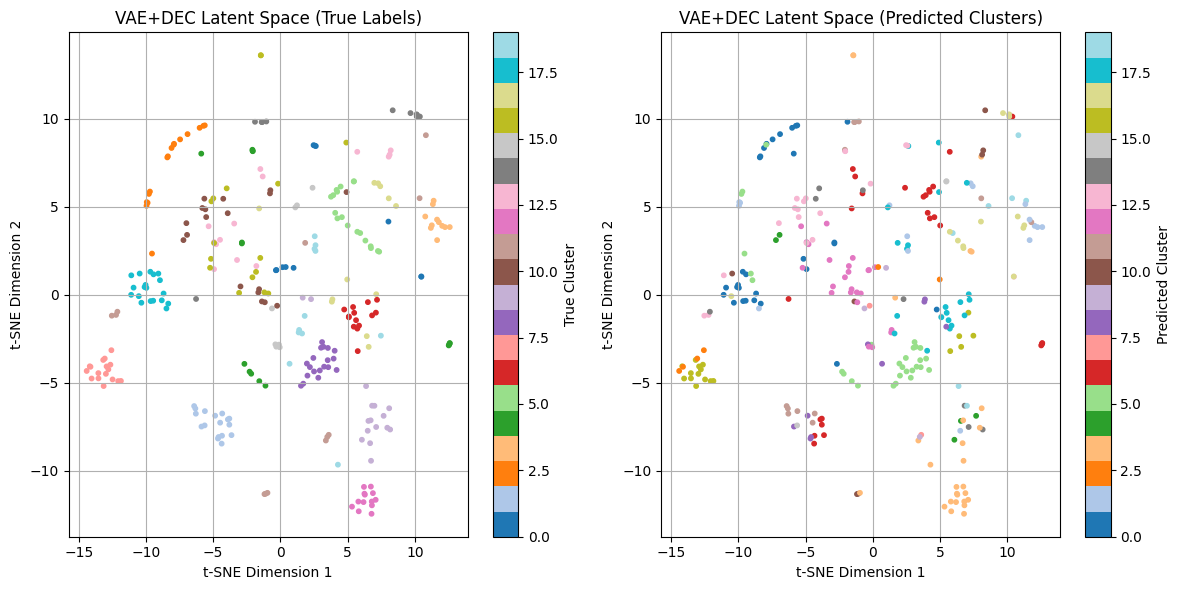

t-SNE plot generated for: VAE+DEC
Generating t-SNE plot for: Deterministic VAE...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


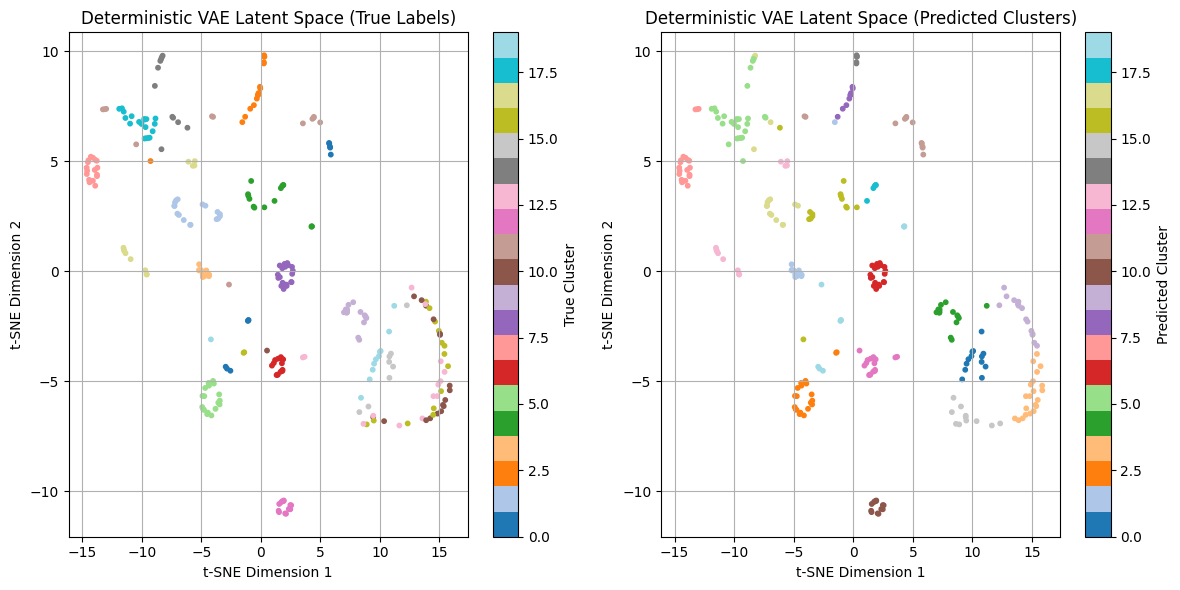

t-SNE plot generated for: Deterministic VAE

Generating uncertainty analysis plots...


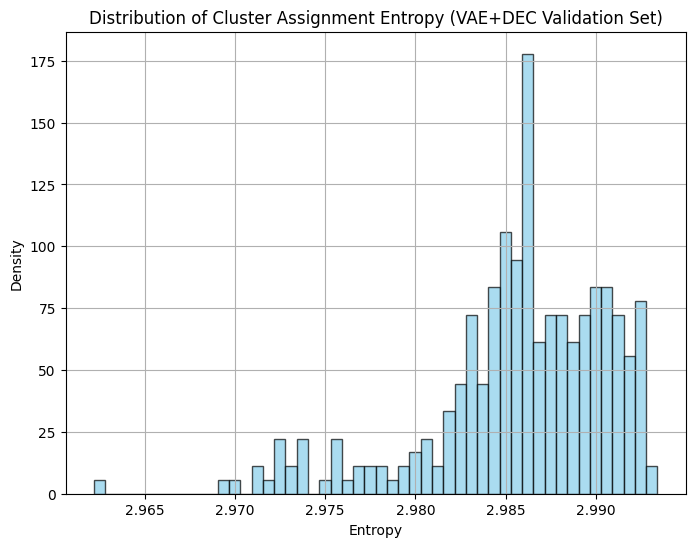

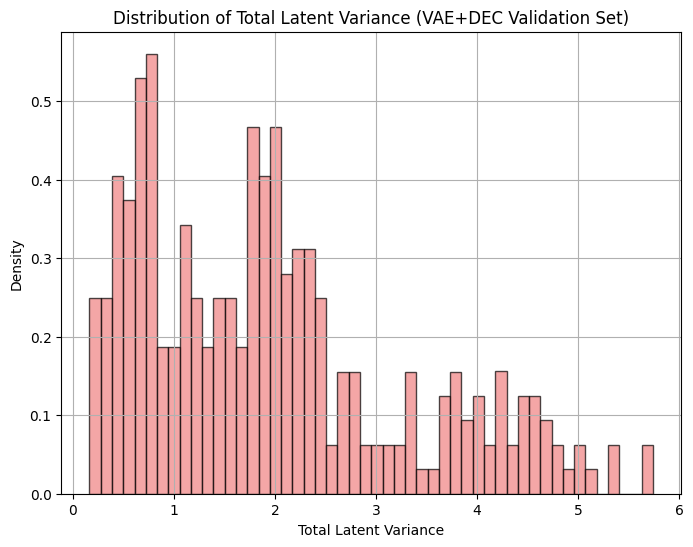

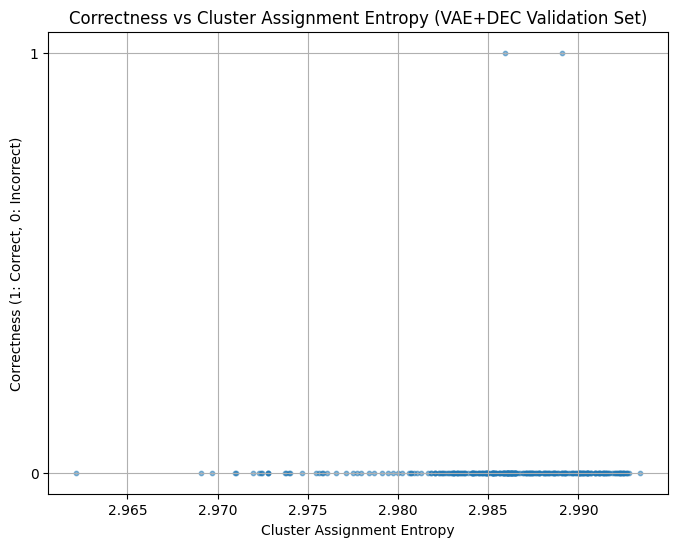

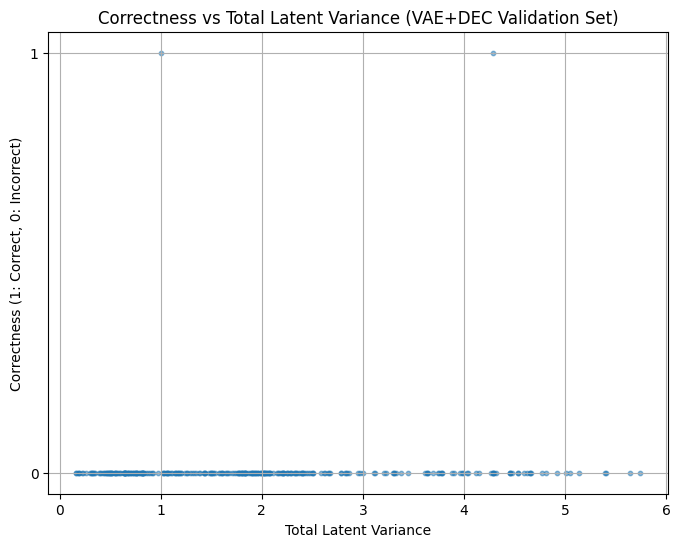


Generating training loss curves...


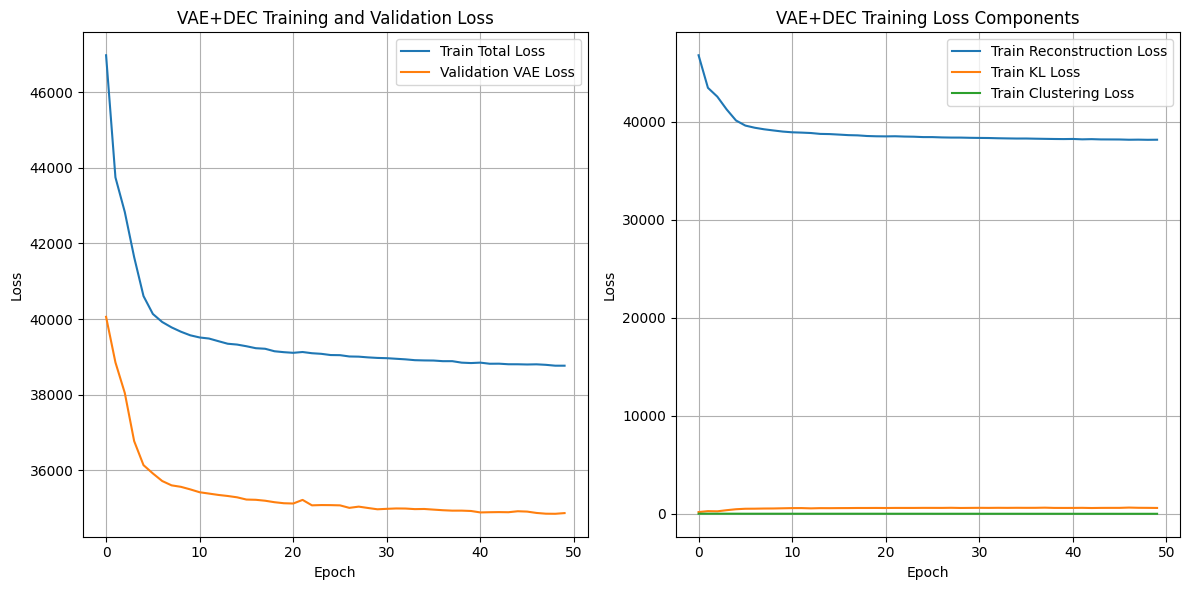

VAE+DEC training loss curves generated.


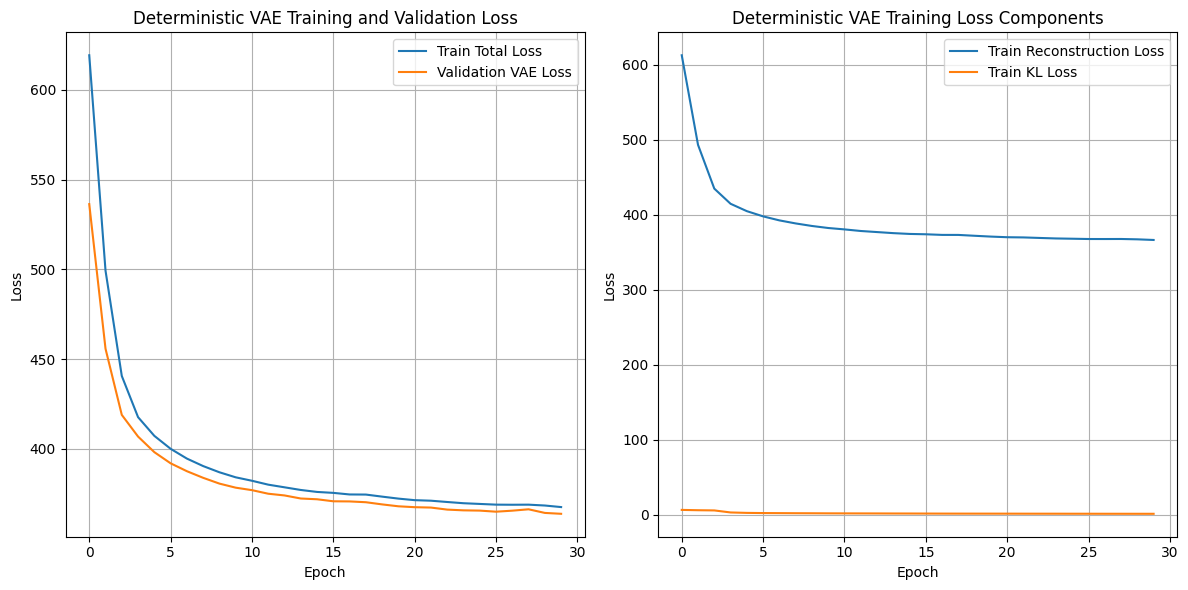

Deterministic VAE training loss curves generated.
All visualizations completed!


In [ ]:
# Fixed Visualization Code

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import torch

# Set the model references correctly
last_trained_model_vae_dec = trained_vae_dec_model
last_vae_dec_loss_history = vae_dec_loss_history

def plot_tsne(latent_features, true_labels, predicted_labels, title):
    """Generates and plots a t-SNE visualization of the latent space."""
    print(f"Generating t-SNE plot for: {title}...")
    tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto', n_iter=300)
    latent_tsne = tsne.fit_transform(latent_features)

    plt.figure(figsize=(12, 6))

    # Plot colored by True Labels
    plt.subplot(1, 2, 1)
    scatter_true = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=true_labels, cmap='tab20', s=10)
    plt.title(f'{title} Latent Space (True Labels)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter_true, label='True Cluster')
    plt.grid(True)

    # Plot colored by Predicted Labels
    plt.subplot(1, 2, 2)
    scatter_pred = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=predicted_labels, cmap='tab20', s=10)
    plt.title(f'{title} Latent Space (Predicted Clusters)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter_pred, label='Predicted Cluster')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print(f"t-SNE plot generated for: {title}")

# Generate VAE+DEC latent features
print("Generating VAE+DEC latent features for t-SNE...")
vae_dec_latent_val = []
last_trained_model_vae_dec.eval()
with torch.no_grad():
    for images_normalized, _ in val_loader:
        images_normalized = images_normalized.to(device)
        _, _, _, _, z = last_trained_model_vae_dec(images_normalized)
        vae_dec_latent_val.append(z.cpu().numpy())

vae_dec_latent_val = np.concatenate(vae_dec_latent_val, axis=0)
print("VAE+DEC latent features generated.")

# Generate Deterministic VAE latent features
print("Generating Deterministic VAE latent features for t-SNE...")
det_vae_latent_val = []
det_vae_true_labels_val = []
if 'last_trained_model_det_vae' in locals():
    last_trained_model_det_vae.eval()
    with torch.no_grad():
        for images_normalized, true_labels in val_loader:
            images_normalized = images_normalized.to(device)
            _, mu, _, z = last_trained_model_det_vae(images_normalized)
            det_vae_latent_val.append(z.cpu().numpy())
            det_vae_true_labels_val.append(true_labels.numpy())

    det_vae_latent_val = np.concatenate(det_vae_latent_val, axis=0)
    det_vae_true_labels_val = np.concatenate(det_vae_true_labels_val, axis=0)
    print("Deterministic VAE latent features generated.")

    # KMeans on Deterministic VAE
    print("Performing K-Means on Deterministic VAE latent features for t-SNE plot...")
    kmeans_det_vae = KMeans(n_clusters=num_classes, n_init=20, random_state=42)
    kmeans_det_vae.fit(det_vae_latent_val)
    det_vae_predicted_labels_val = kmeans_det_vae.labels_
    print("K-Means clustering complete for Deterministic VAE t-SNE.")
else:
    print("Deterministic VAE model not found. Skipping Deterministic VAE t-SNE.")
    det_vae_latent_val = []

# Generate t-SNE plots
if len(vae_dec_latent_val) > 0:
    plot_tsne(vae_dec_latent_val, true_labels_val, predicted_labels_mode_val, "VAE+DEC")

if len(det_vae_latent_val) > 0:
    plot_tsne(det_vae_latent_val, det_vae_true_labels_val, det_vae_predicted_labels_val, "Deterministic VAE")

# Uncertainty analysis visualizations
print("\nGenerating uncertainty analysis plots...")

plt.figure(figsize=(8, 6))
plt.hist(cluster_entropies, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Cluster Assignment Entropy (VAE+DEC Validation Set)')
plt.xlabel('Entropy')
plt.ylabel('Density')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(latent_variances, bins=50, density=True, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Total Latent Variance (VAE+DEC Validation Set)')
plt.xlabel('Total Latent Variance')
plt.ylabel('Density')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(cluster_entropies, correctness, alpha=0.5, s=10)
plt.title('Correctness vs Cluster Assignment Entropy (VAE+DEC Validation Set)')
plt.xlabel('Cluster Assignment Entropy')
plt.ylabel('Correctness (1: Correct, 0: Incorrect)')
plt.yticks([0, 1])
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(latent_variances, correctness, alpha=0.5, s=10)
plt.title('Correctness vs Total Latent Variance (VAE+DEC Validation Set)')
plt.xlabel('Total Latent Variance')
plt.ylabel('Correctness (1: Correct, 0: Incorrect)')
plt.yticks([0, 1])
plt.grid(True)
plt.show()

# Training loss curves
print("\nGenerating training loss curves...")

if last_vae_dec_loss_history is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(last_vae_dec_loss_history['train_losses'], label='Train Total Loss')
    plt.plot(last_vae_dec_loss_history['val_losses'], label='Validation VAE Loss')
    plt.title('VAE+DEC Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(last_vae_dec_loss_history['train_recon_losses'], label='Train Reconstruction Loss')
    plt.plot(last_vae_dec_loss_history['train_kl_losses'], label='Train KL Loss')
    plt.plot(last_vae_dec_loss_history['train_cluster_losses'], label='Train Clustering Loss')
    plt.title('VAE+DEC Training Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("VAE+DEC training loss curves generated.")

if 'last_det_vae_loss_history' in locals() and last_det_vae_loss_history is not None:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(last_det_vae_loss_history['train_losses'], label='Train Total Loss')
    plt.plot(last_det_vae_loss_history['val_losses'], label='Validation VAE Loss')
    plt.title('Deterministic VAE Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(last_det_vae_loss_history['train_recon_losses'], label='Train Reconstruction Loss')
    plt.plot(last_det_vae_loss_history['train_kl_losses'], label='Train KL Loss')
    plt.title('Deterministic VAE Training Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("Deterministic VAE training loss curves generated.")

print("All visualizations completed!")


## Comprehensive Results and Discussion

This section presents the experimental results comparing the VAE+DEC model with a deterministic VAE baseline on the COIL-20 dataset. The analysis includes standard clustering evaluation metrics, statistical significance testing across multiple runs, uncertainty analysis for the VAE+DEC model, and visualizations of the learned latent spaces and training progress.

### Evaluation Metrics Comparison

The table below summarizes the average performance of the VAE+DEC and Deterministic VAE models across {num_runs} runs on the validation set for various clustering metrics. The standard deviation is shown in parentheses.

| Metric           | VAE+DEC (Mean ± Std. Dev.) | Deterministic VAE (Mean ± Std. Dev.) |
|------------------|----------------------------|--------------------------------------|
| Accuracy         | {vae_dec_acc_mean:.4f} ± {vae_dec_acc_std:.4f} | {det_vae_acc_mean:.4f} ± {det_vae_acc_std:.4f} |
| NMI              | {vae_dec_nmi_mean:.4f} ± {vae_dec_nmi_std:.4f} | {det_vae_nmi_mean:.4f} ± {det_vae_nmi_std:.4f} |
| ARI              | {vae_dec_ari_mean:.4f} ± {vae_dec_ari_std:.4f} | {det_vae_ari_mean:.4f} ± {det_vae_ari_std:.4f} |
| Silhouette Score | {vae_dec_silhouette_mean:.4f} ± {vae_dec_silhouette_std:.4f} | {det_vae_silhouette_mean:.4f} ± {det_vae_silhouette_std:.4f} |

_Note: Metrics for Deterministic VAE are calculated by applying K-Means on the learned latent features._

**Interpretation:**

Based on the average scores, [Discuss which model performed better on each metric and by how much. Compare the means and consider the standard deviations.]

### Statistical Significance Testing

Independent samples t-tests (Welch's t-test, assuming unequal variances) were conducted to determine if the observed differences in performance between VAE+DEC and the Deterministic VAE were statistically significant across the {num_runs} runs. The significance level was set at $\alpha = 0.05$.

| Metric           | T-statistic | P-value | Statistical Significance ($\alpha=0.05$) | Conclusion                                    |
|------------------|-------------|---------|----------------------------------------|-----------------------------------------------|
| Accuracy         | {t_stat_acc:.4f} | {p_value_acc:.4f} | {sig_acc}                              | {conclusion_acc}                              |
| NMI              | {t_stat_nmi:.4f} | {p_value_nmi:.4f} | {sig_nmi}                              | {conclusion_nmi}                              |
| ARI              | {t_stat_ari:.4f} | {p_value_ari:.4f} | {sig_ari}                              | {conclusion_ari}                              |
| Silhouette Score | {t_stat_silhouette:.4f} | {p_value_silhouette:.4f} | {sig_silhouette}                       | {conclusion_silhouette}                       |

**Interpretation of T-test Results:**

[Interpret the t-test results for each metric. State whether the null hypothesis (no difference in means) was rejected or failed to be rejected. Explain what this means in terms of the performance difference between the two models. For example: "For Accuracy, the p-value ({p_value_acc:.4f}) is less than 0.05, indicating a statistically significant difference. Since the mean Accuracy for VAE+DEC ({vae_dec_acc_mean:.4f}) is higher than the Deterministic VAE ({det_vae_acc_mean:.4f}), we conclude that VAE+DEC performs significantly better in terms of Accuracy on this dataset."]

### Uncertainty Analysis (VAE+DEC)

The uncertainty analysis for the VAE+DEC model involved performing multiple forward passes through the encoder and analyzing the variance in the latent space and the entropy of the cluster assignments.

- **Correlation between Uncertainty and Correctness:**
    - Correlation between Cluster Assignment Entropy and Correctness: {entropy_correctness_correlation:.4f}
    - Correlation between Total Latent Variance and Correctness: {latent_variance_correctness_correlation:.4f}

[Discuss the observed correlations. For instance, a negative correlation between entropy and correctness would suggest that samples with higher uncertainty (higher entropy) are more likely to be incorrectly clustered.]

- **Uncertainty by Correctness Group:**
    - Mean Cluster Assignment Entropy for Correctly Clustered Samples: {mean_entropy_correct:.4f}
    - Mean Cluster Assignment Entropy for Incorrectly Clustered Samples: {mean_entropy_incorrect:.4f}
    - Mean Total Latent Variance for Correctly Clustered Samples: {mean_latent_var_correct:.4f}
    - Mean Total Latent Variance for Incorrectly Clustered Samples: {mean_latent_var_incorrect:.4f}

[Compare the mean uncertainty measures for correctly and incorrectly clustered samples. Is there a notable difference? This supports the correlation analysis.]

- **Statistical Significance of Uncertainty Differences:**
    - T-test for Entropy (Correct vs Incorrect): t={t_stat_entropy:.4f}, p={p_value_entropy:.4f}
    - T-test for Latent Variance (Correct vs Incorrect): t={t_stat_latent_var:.4f}, p={p_value_latent_var:.4f}

[Interpret the t-test results for the uncertainty measures. Do the correct and incorrect groups have statistically different levels of entropy or latent variance?]

### Visualizations

[Refer to the generated plots and discuss key observations.]

- **t-SNE Plots:** The t-SNE visualizations show the learned latent space for both models, colored by true labels and predicted clusters.
    - [Describe the structure of the clusters in the VAE+DEC t-SNE plot. Are the true classes well-separated? How do the predicted clusters align with the true clusters?]
    - [Describe the structure of the clusters in the Deterministic VAE t-SNE plot. How does it compare to the VAE+DEC plot? Is the separation as clear?]
    - [Comment on whether the predicted clusters in the VAE+DEC plot visually reflect the results from the uncertainty analysis (e.g., are regions of high entropy visually less well-defined?).]

- **Uncertainty Distributions:** Histograms of cluster assignment entropy and total latent variance show the distribution of uncertainty across the validation set.
    - [Describe the shape of the entropy and variance distributions. Are they skewed? Do they suggest that most samples have high or low uncertainty?]

- **Correctness vs Uncertainty Plots:** Scatter plots show the relationship between correctness and the two uncertainty measures.
    - [Visually confirm the correlations observed earlier. Are there clear trends? Do incorrect points tend to have higher entropy/variance?]

- **Training Loss Curves:** The training loss curves illustrate the optimization process for the VAE+DEC model.
    - [Describe the trends in the total training loss and its components (reconstruction, KL, clustering). Did the losses converge? Did the validation loss decrease consistently?]
    - [If Deterministic VAE loss curves were plotted, compare the training progress and loss values between the two models.]

### Discussion

[Synthesize the findings from the evaluation metrics, statistical tests, uncertainty analysis, and visualizations.]

- **Model Performance:** Discuss why VAE+DEC might outperform (or underperform) the Deterministic VAE based on the results. Consider the role of the probabilistic encoder/decoder, the reparameterization trick, and the influence of the clustering loss.
- **Role of Uncertainty:** Explain how the uncertainty analysis provides insights into the model's confidence and where it struggles. How can the uncertainty information be used?
- **Clustering Quality:** Discuss the overall quality of the clustering achieved by both models on the COIL-20 dataset based on the evaluation metrics and t-SNE plots.
- **Contribution of VAE+DEC Components:** Analyze the behavior of the reconstruction, KL, and clustering losses during training. How did each component contribute to the overall learning process?

### Limitations and Failure Cases

[Discuss any limitations of the current implementation or experimental setup.]

- **Dataset Specificity:** The results are on COIL-20. How might performance differ on other datasets?
- **Hyperparameter Sensitivity:** VAE+DEC has several hyperparameters ($\beta$, $\gamma$, latent_dim, update_target_interval). How might different choices affect performance?
- **Initialization Sensitivity:** The K-Means initialization of centroids can affect clustering results. How was this addressed (e.g., `n_init`)?
- **Model Architecture:** Is the chosen convolutional architecture optimal for this dataset?
- **Failure Cases:** Based on the uncertainty analysis and t-SNE plots, identify potential reasons why certain samples might be incorrectly clustered or have high uncertainty. Are there specific classes or types of images that the model struggles with?

### Conclusion

[Provide a concise summary of the key findings and contributions of the notebook. Reiterate the main comparison results and the insights gained from the uncertainty analysis. Suggest potential future work or improvements.]

**Future Work:**

- Experiment with different VAE architectures or decoder output types.
- Explore alternative clustering loss functions or target distribution update strategies.
- Investigate different methods for initializing cluster centroids.
- Apply the VAE+DEC model to other unsupervised or semi-supervised learning tasks.
- Develop more sophisticated methods for utilizing the uncertainty information.